In [25]:
from __future__ import print_function
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.io import read_image
from torch.autograd import Variable
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from PIL import Image
import gc
import saliency.core as saliency
from torchvision import models, transforms


cudnn.benchmark = True

In [26]:
def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)


In [114]:
model = models.inception_v3(pretrained=True, init_weights=False).cuda()
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
BLACK  = Image.fromarray(np.zeros((299, 299, 3), dtype=np.uint8))
BLACK = preprocess(BLACK)
BLACK = torch.Tensor(BLACK[None]) # adds extra first dimension 

In [98]:
def straight_path_images(model, images, n_steps):
    
    x_diff = images - BLACK
    path_images = []
    
    for alpha in np.linspace(0, 1, n_steps):
        x_step = BLACK + alpha * x_diff
        path_images.append(x_step)
    
    path_images = torch.stack(path_images).transpose(0, 1)

    # returns x sequence
    return path_images

In [118]:
images = torch.stack([preprocess(Image.open("doberman.png"))])
sequence = straight_path_images(model, images, 25)


In [110]:
def IG(model, sequence, class_idxs):
    image_shape = sequence.shape[2:]
    batchSize = sequence.shape[0]
    frames = sequence.shape[1]

    model.eval()
    sequence = sequence

    for param in model.parameters():
        param.requires_grad = True 
    sequence.requires_grad = True
    
    classes = np.repeat(class_idxs, frames)

    reshaped_sequence = sequence.reshape((batchSize*frames,)+image_shape)
    
    output = model(reshaped_sequence)

    output = torch.nn.Softmax(dim=1)(output)
    output = output[np.arange(batchSize*frames), classes]  # index that particular class for each image

    gradients = torch.autograd.grad(output, reshaped_sequence, grad_outputs=torch.ones_like(output))[0].view(sequence.shape).detach()
    summands =  (gradients[:,1:] * (sequence[:,1:]-sequence[:,:-1]))

    return summands.sum(1).detach().cpu().numpy()
            
saliency_IG = IG(model, sequence, class_idxs=[236]).transpose(0,2,3,1)


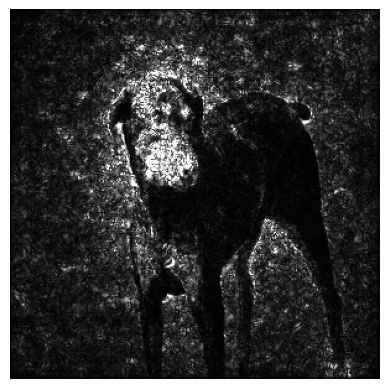

In [111]:
ShowGrayscaleImage(saliency.VisualizeImageGrayscale(saliency_IG[0]))

In [124]:
def IDGI(model, sequence, class_idxs):

    image_shape = sequence.shape[2:]
    batchSize = sequence.shape[0]
    frames = sequence.shape[1]

    for param in model.parameters():
        param.requires_grad = True 
    
    reshaped_sequence = sequence.reshape((batchSize*frames,)+image_shape)
    reshaped_sequence.requires_grad = True
    reshaped_sequence = reshaped_sequence.cuda()

    classes = np.repeat(class_idxs, frames)
    output = model(reshaped_sequence)

    output = torch.nn.Softmax(dim=1)(output)
    output = output[np.arange(batchSize*frames), classes]  # index that particular class for each image

    gradients = torch.autograd.grad(output, reshaped_sequence, grad_outputs=torch.ones_like(output))[0].view(sequence.shape).detach()
    output = output.detach().view((batchSize, frames))

    # return summands.sum(1).detach().abs().mean(1).cpu()
                
    result = torch.zeros((batchSize,)+image_shape).cuda()
    for i in range(sequence.shape[1] - 1):
        # We ignore the last gradient, e.g., the gradient of on the original image, since IDGI requires the prediction difference component, e.g., d.
        d = output[:,i+1] - output[:, i]
        element_product = gradients[:,i]**2
        result += element_product*d.view(-1,1,1,1)/element_product.sum((1,2,3)).view(-1,1,1,1)
    return result.detach().cpu().numpy().transpose(0,2,3,1)

saliency_IDGI = IDGI(model, sequence, class_idxs=[236])


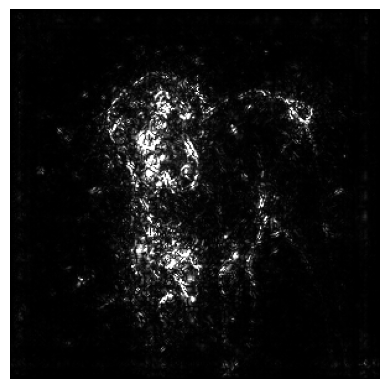

In [125]:
ShowGrayscaleImage(saliency.VisualizeImageGrayscale(saliency_IDGI[0]))